<a href="https://colab.research.google.com/github/mehdi-abbasi/ChatPythonSocket/blob/master/hand_gesture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing Dataset:

In [11]:
! wget http://www-rech.telecom-lille.fr/shrec2017-hand/HandGestureDataset_SHREC2017.tar.gz

--2022-08-03 21:41:08--  http://www-rech.telecom-lille.fr/shrec2017-hand/HandGestureDataset_SHREC2017.tar.gz
Resolving www-rech.telecom-lille.fr (www-rech.telecom-lille.fr)... 193.48.251.100
Connecting to www-rech.telecom-lille.fr (www-rech.telecom-lille.fr)|193.48.251.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6305395695 (5.9G) [application/x-gzip]
Saving to: ‘HandGestureDataset_SHREC2017.tar.gz.1’

HandGestureDataset_ 100%[===================>]   5.87G  30.1MB/s    in 3m 21s  

2022-08-03 21:44:29 (30.0 MB/s) - ‘HandGestureDataset_SHREC2017.tar.gz.1’ saved [6305395695/6305395695]



In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
! mkdir dhg-dataset-2017
! tar -xzf /content/drive/MyDrive/Colab-Notebooks/HandGestureDataset_SHREC2017.tar.gz -C dhg-dataset-2017

mkdir: cannot create directory ‘dhg-dataset-2017’: File exists


# a python script which charge and display a sequence:

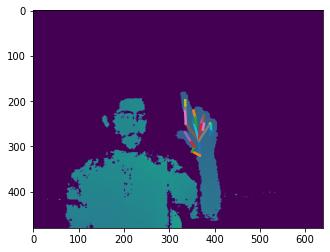

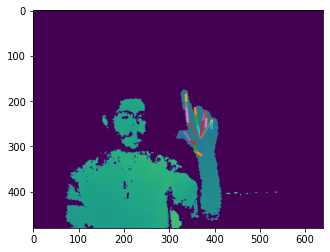

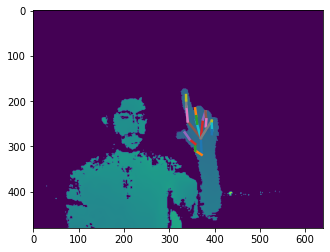

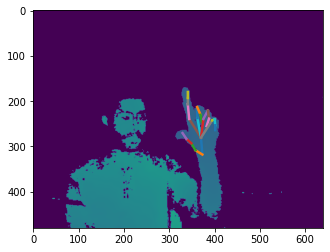

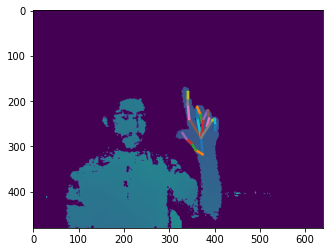

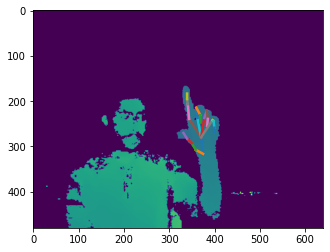

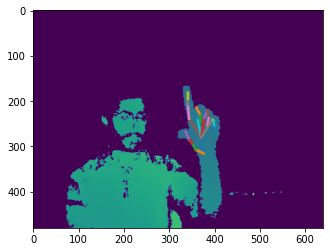

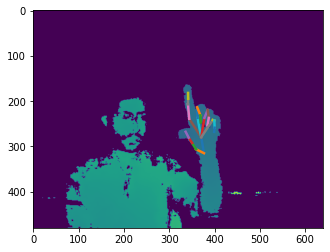

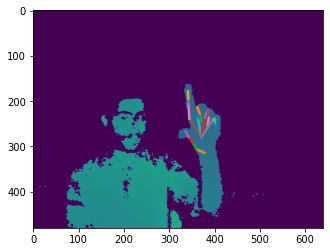

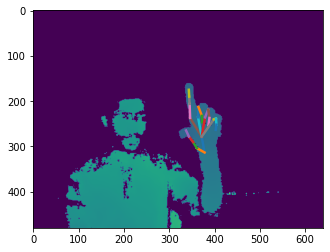

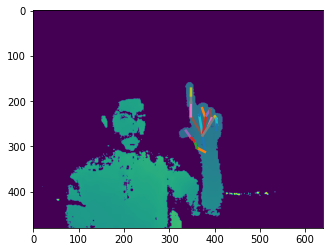

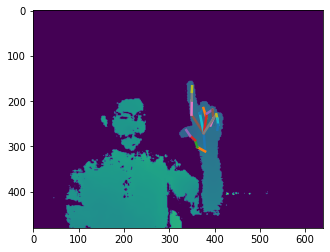

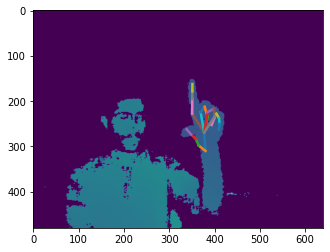

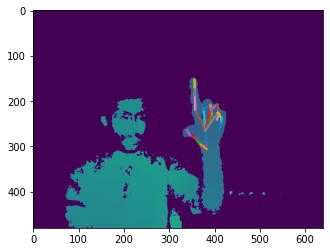

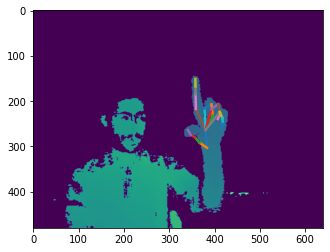

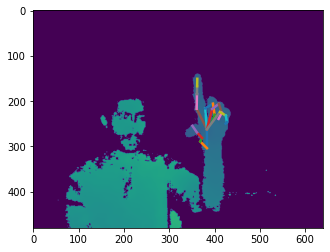

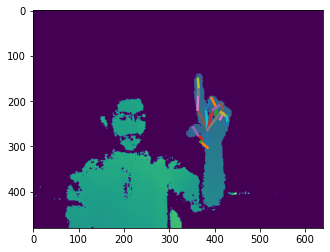

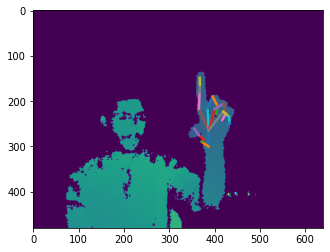

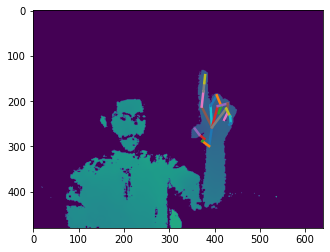

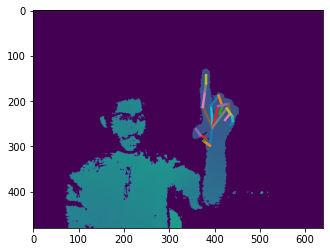

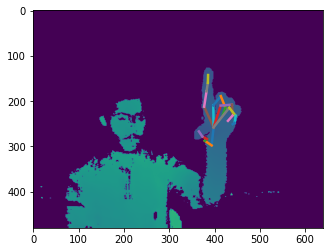

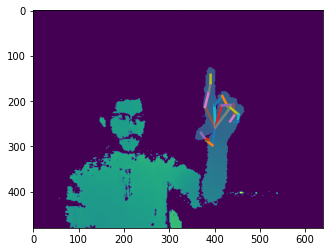

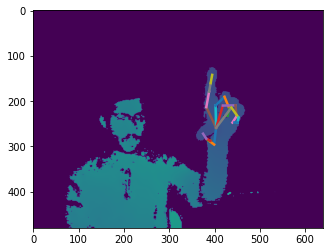

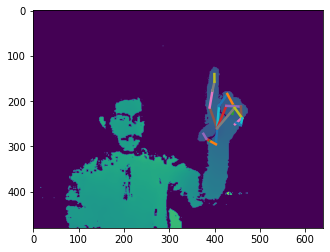

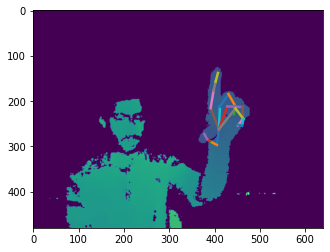

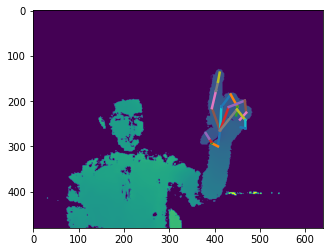

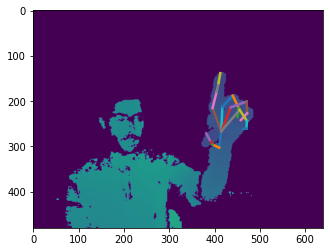

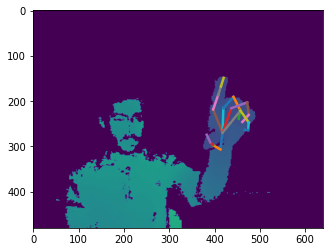

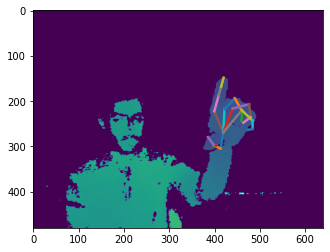

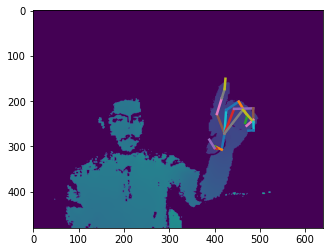

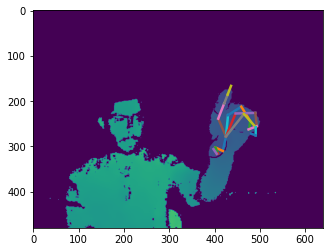

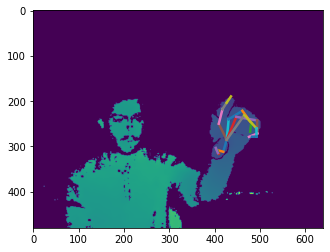

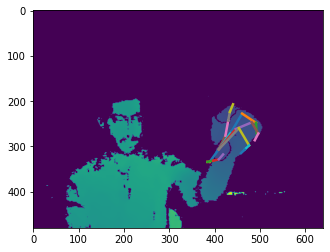

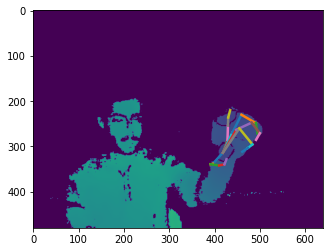

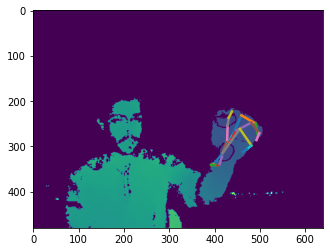

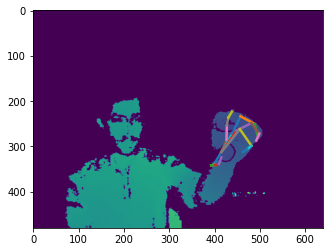

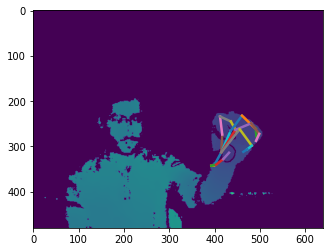

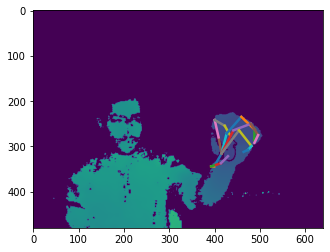

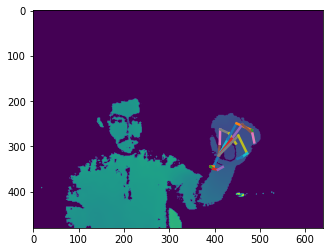

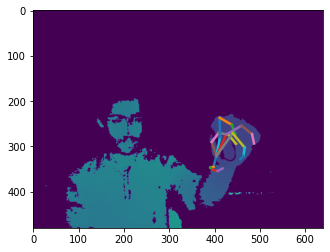

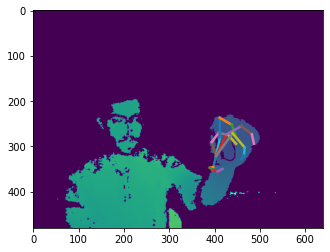

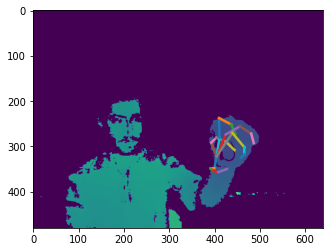

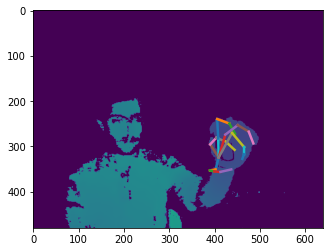

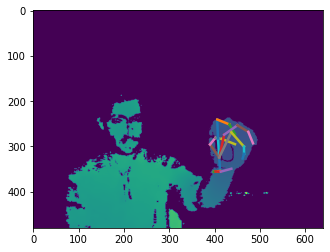

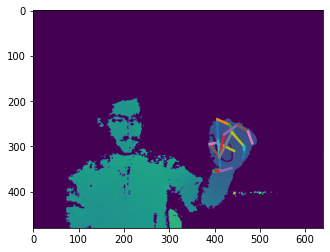

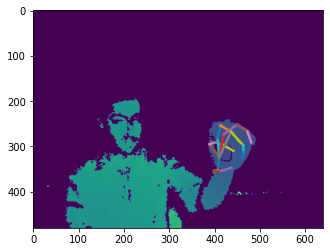

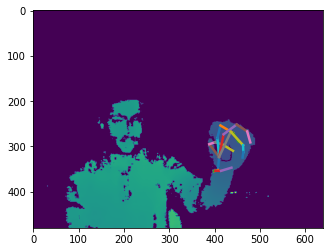

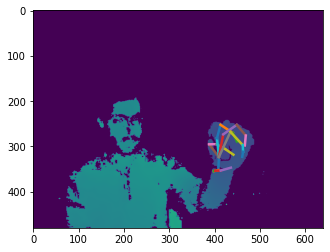

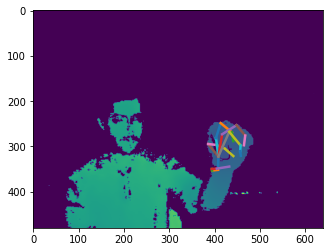

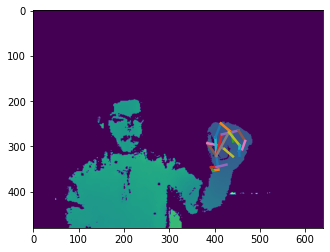

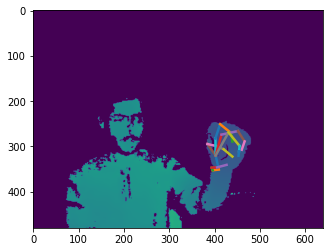

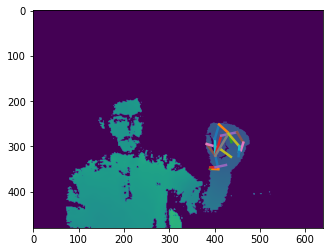

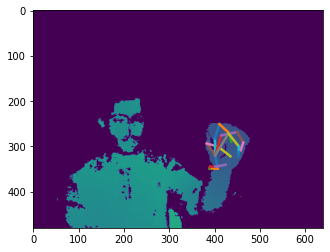

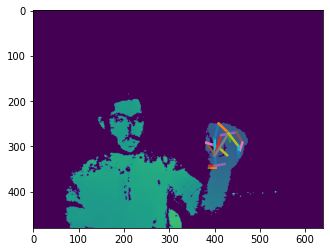

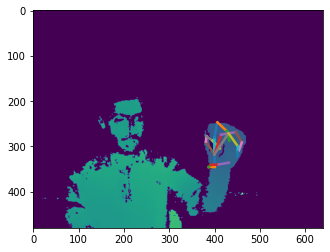

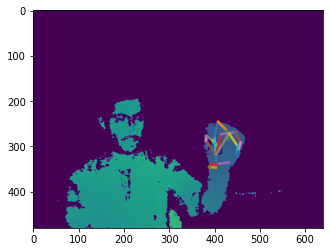

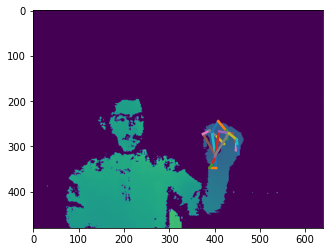

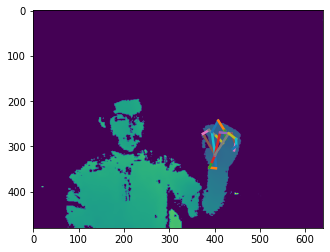

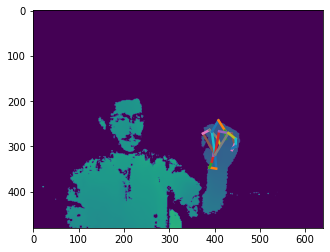

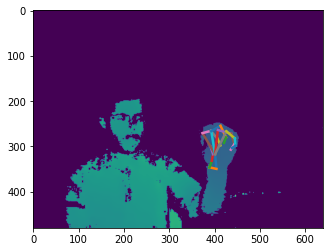

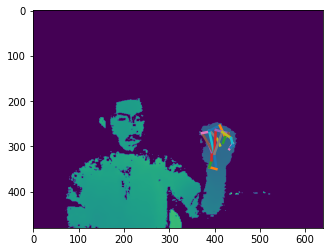

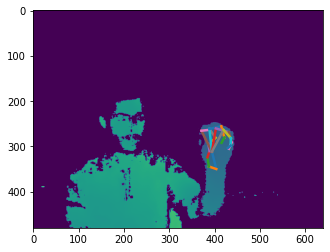

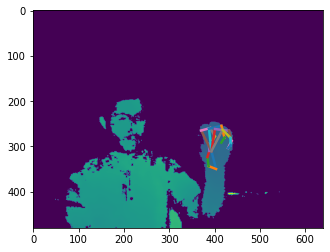

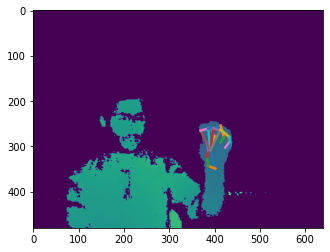

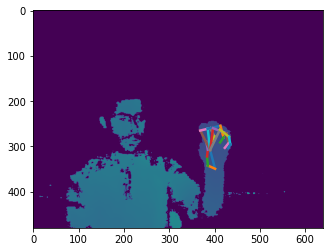

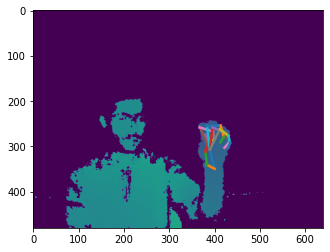

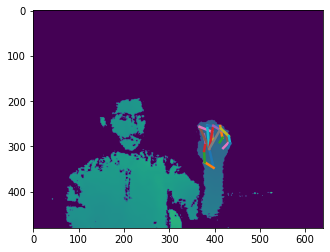

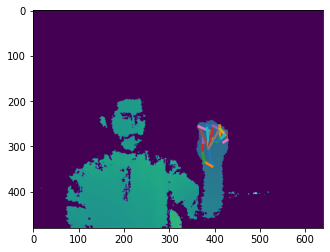

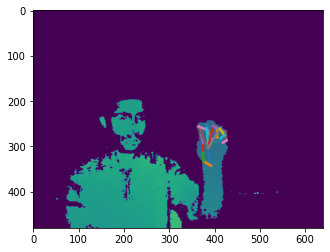

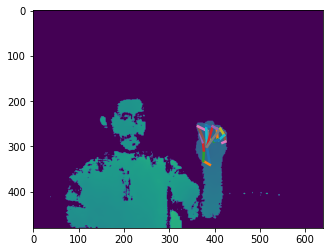

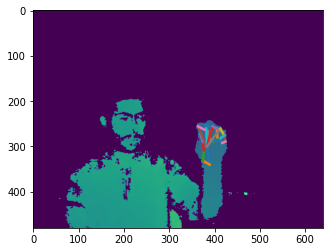

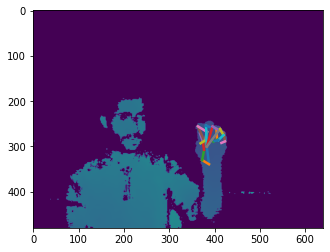

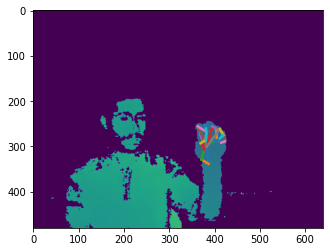

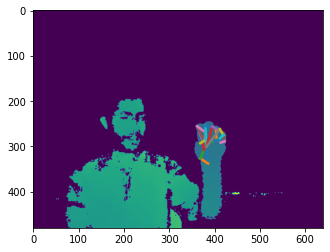

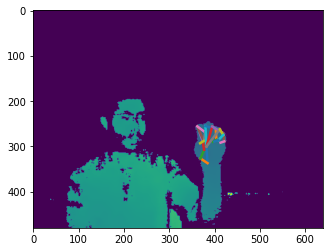

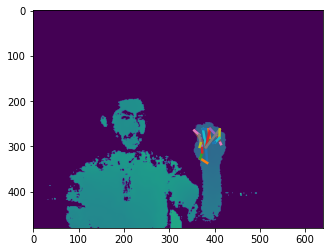

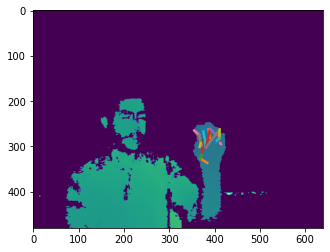

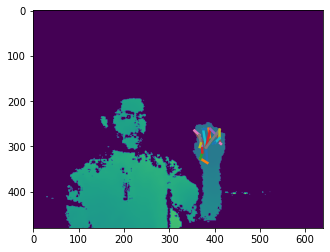

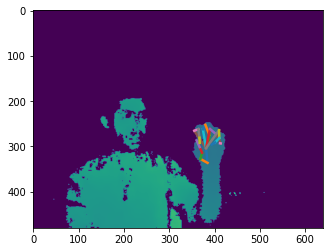

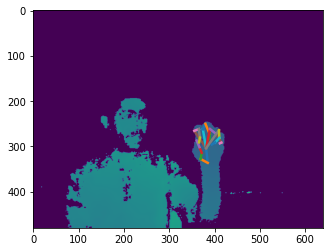

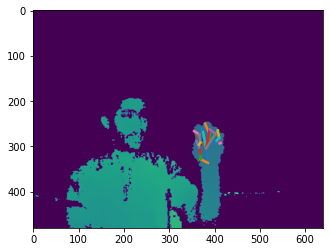

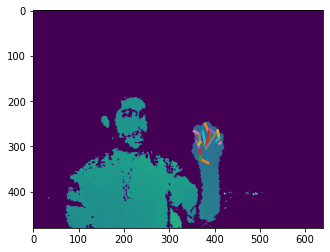

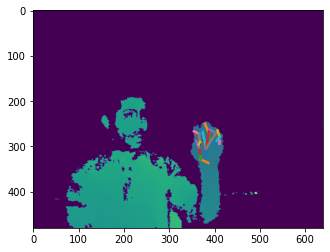

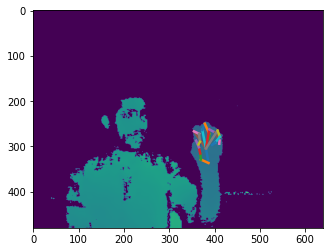

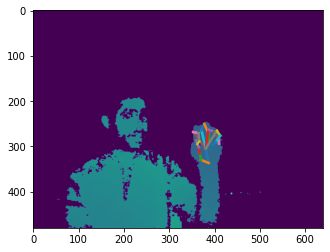

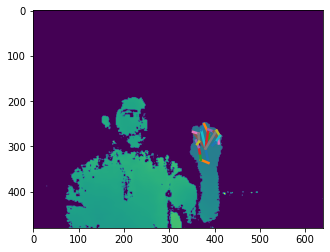

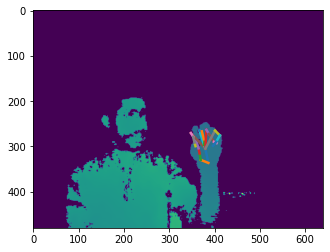

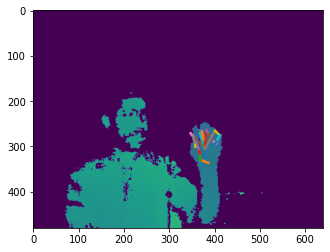

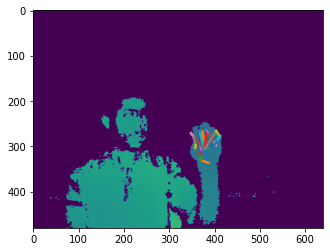

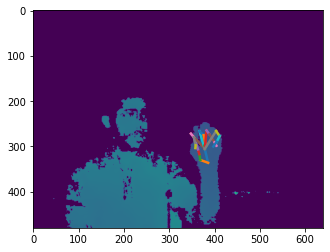

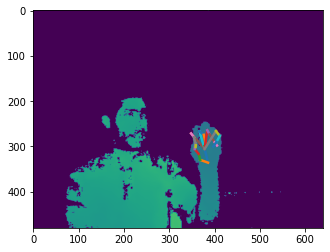

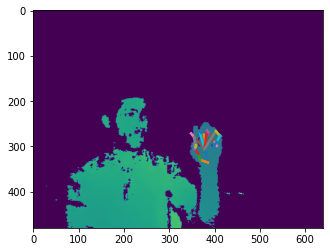

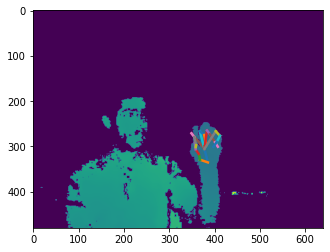

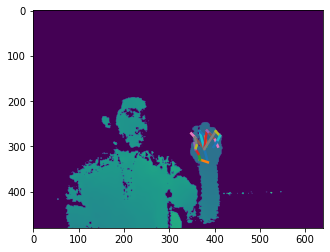

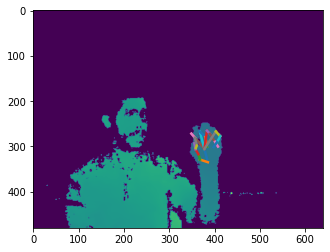

In [13]:
import numpy as np
import imageio
import os
import matplotlib.pyplot as plt

##### To modify

root_datase = '/content/dhg-dataset-2017/HandGestureDataset_SHREC2017'

idx_gesture = 1
idx_subject = 1
idx_finger = 1
idx_essai = 1

####

# Idx of the bones in the hand skeleton to display it.

bones = np.array([
	[0, 1],
    [0, 2],
    [2, 3],
    [3, 4],
    [4, 5],
    [1, 6],
    [6, 7],
    [7, 8],
    [8, 9],
    [1, 10],
    [10, 11],
    [11, 12],
    [12, 13],
    [1, 14],
    [14, 15],
    [15, 16],
    [16, 17],
    [1, 18],
    [18, 19],
    [19, 20],
    [20, 21]
    ]
);

#Path of the gesture


path_gesture = root_datase + '/gesture_' + str(idx_gesture) + '/finger_' \
			+ str(idx_finger) + '/subject_' + str(idx_subject) + '/essai_' + str(idx_essai)+'/'



if os.path.isdir(path_gesture):

	path_skeletons_image = path_gesture+ '/skeletons_image.txt'

	skeletons_image = np.loadtxt(path_skeletons_image)

	pngDepthFiles = np.zeros([skeletons_image.shape[0], 480, 640])
	skeletons_display = np.zeros([skeletons_image.shape[0], 2, 2, 21])

	for id_image in range(0, skeletons_image.shape[0]):
		pngDepthFiles[id_image,:] = imageio.imread(path_gesture+str(id_image)+'_depth.png')

		x = np.zeros([2, bones.shape[0]])
		y = np.zeros([2, bones.shape[0]])

		ske = skeletons_image[id_image,:]

		for idx_bones in range(0, bones.shape[0]):
			joint1 = bones[idx_bones, 0]
			joint2 = bones[idx_bones, 1]

			pt1 = ske[joint1*2:joint1*2+2]
			pt2 = ske[joint2*2:joint2*2+2]

			x[0,idx_bones] = pt1[0]
			x[1,idx_bones] = pt2[0]
			y[0,idx_bones] = pt1[1]
			y[1,idx_bones] = pt2[1]

		skeletons_display[id_image, 0, : , :] = x
		skeletons_display[id_image, 1, : , :] = y

	for id_image in range(0, skeletons_image.shape[0]):
		plt.clf()
		plt.imshow(pngDepthFiles[id_image,:])
		plt.plot(skeletons_display[id_image, 0, : , :], skeletons_display[id_image, 1, : , :], linewidth=2.5)
		plt.pause(0.01)


else:
	print ('There is no gesture in the path {}'.format(path_gesture))


# Importing Libraries:

In [15]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input,Dense,Flatten,Dropout
from keras.layers.convolutional import Conv1D,AveragePooling1D,Conv2D
from keras.layers.merge import concatenate
from scipy.ndimage import interpolation
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

# Data Preproceseing:

In [23]:
train_data = np.loadtxt('/content/dhg-dataset-2017/HandGestureDataset_SHREC2017/train_gestures.txt').astype(int)
test_data = np.loadtxt('/content/dhg-dataset-2017/HandGestureDataset_SHREC2017/test_gestures.txt').astype(int)

In [24]:
train_data = shuffle(train_data)

In [25]:
idx_gesture = 0
idx_subject = 0
idx_finger = 0
idx_essai = 0

root_dir = '/content/dhg-dataset-2017/HandGestureDataset_SHREC2017/'

train = []
for idx_gesture,idx_finger,idx_subject,idx_essai,s_labels,d_labels,size_sequence in train_data:
  dest_path = root_dir + F'gesture_{idx_gesture}/finger_{idx_finger}/subject_{idx_subject}/essai_{idx_essai}/skeletons_world.txt'
  data = np.transpose(np.loadtxt(dest_path))
  train.append(data)

test = []
for idx_gesture,idx_finger,idx_subject,idx_essai,s_labels,d_labels,size_sequence in test_data:
  dest_path = root_dir + F'gesture_{idx_gesture}/finger_{idx_finger}/subject_{idx_subject}/essai_{idx_essai}/skeletons_world.txt'
  data = np.transpose(np.loadtxt(dest_path))
  test.append(data)

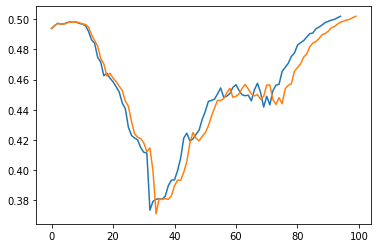

In [26]:
plt.plot(test[0][0])
seq = interpolation.zoom(test[0][0],100/95)

plt.plot(seq)
plt.show()

In [27]:
train_seq = []
for s in train:
  for i in range(66):
    train_seq.append(interpolation.zoom(s[i,:],100/s.shape[1]))

    
test_seq = []
for s in test:
  for i in range(66):
    test_seq.append(interpolation.zoom(s[i,:],100/s.shape[1]))


train_seq = np.reshape(train_seq,(1960,66,100))
test_seq = np.reshape(test_seq,(840,66,100))


In [28]:
y_train14 = train_data[:,4]
y_train28 = train_data[:,5]

y_test14 = test_data[:,4]
y_test28 = test_data[:,5]

In [29]:
x_train = np.zeros((66,1960,100))
for i in range(len(train_seq)):
  for j in range(66):
    x_train[j][i] += train_seq[i][j]

X_train = [data for data in x_train]
Y_train14 = to_categorical(y_train14-1, num_classes=14)
Y_train28 = to_categorical(y_train28-1, num_classes=28)

x_test = np.zeros((66,840,100))
for i in range(len(test_seq)):
  for j in range(66):
    x_test[j][i] += test_seq[i][j]
    
X_test = [data for data in x_test]
Y_test14 = to_categorical(y_test14-1, num_classes=14)
Y_test28 = to_categorical(y_test28-1, num_classes=28)

# Model:

In [30]:
inp = []
out = []
for i in range(66):
  input_1 = Input(shape=(100,1))
  x = Conv1D(filters=8, kernel_size=3, activation='relu')(input_1)
  x = AveragePooling1D(pool_size=2)(x)
  x = Conv1D(filters=8, kernel_size=1, activation='relu')(x)
  x = AveragePooling1D(pool_size=2)(x)
  x = Conv1D(filters=4, kernel_size=1, activation='relu')(x)
  x = AveragePooling1D(pool_size=2)(x)
  flat_1 = Flatten()(x)

  # input_2 = Input(shape=(100,1))
  x = AveragePooling1D(pool_size=2)(input_1)
  x = AveragePooling1D(pool_size=2)(x)
  x = AveragePooling1D(pool_size=2)(x)
  flat_2 = Flatten()(x)

  # input_3 = Input(shape=(100,1))
  x = Conv1D(filters=8, kernel_size=7, activation='relu')(input_1)
  x = AveragePooling1D(pool_size=2)(x)
  x = Conv1D(filters=8, kernel_size=7, activation='relu')(x)
  x = AveragePooling1D(pool_size=2)(x)
  x = Conv1D(filters=4, kernel_size=7, activation='relu')(x)
  x = AveragePooling1D(pool_size=2)(x)
  flat_3 = Flatten()(x)

  merged = concatenate([flat_1, flat_2, flat_3])

  inp.append(input_1)
  out.append(merged)

out_merged = concatenate(out)
dropout = keras.layers.Dropout(0.2)(out_merged)
dense_1 = Dense(1996, activation='relu')(dropout)
output = Dense(14, activation='softmax')(dense_1)

In [31]:
# Implementing Negative log-likelihood loss function
from keras import backend as K
def nll3(y_true, y_pred):
    """ Negative log likelihood. """

    likelihood = K.tf.distributions.Bernoulli(logits=y_pred)

    return - K.sum(likelihood.log_prob(y_true), axis=-1)

In [32]:
model = Model(inputs=inp, outputs=output)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.98,epsilon=1e-08))

# summarize
# print(model.summary())
# plot_model(model, show_shapes=True, to_file='multichannel.png')

In [33]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [34]:
history = model.fit(x=X_train,
                    y=Y_train14,
                    epochs=20,
                    batch_size=32,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_split=0.1)

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.7235 - accuracy: 0.1587
Epoch 1: val_accuracy improved from -inf to 0.33673, saving model to best_model.h5
56/56 [==============================] - 72s 365ms/step - loss: 2.7235 - accuracy: 0.1587 - val_loss: 2.2701 - val_accuracy: 0.3367
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.9228 - accuracy: 0.3793
Epoch 2: val_accuracy improved from 0.33673 to 0.45408, saving model to best_model.h5
56/56 [==============================] - 11s 192ms/step - loss: 1.9228 - accuracy: 0.3793 - val_loss: 1.6943 - val_accuracy: 0.4541
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.3864 - accuracy: 0.5459
Epoch 3: val_accuracy improved from 0.45408 to 0.62755, saving model to best_model.h5
56/56 [==============================] - 12s 215ms/step - loss: 1.3864 - accuracy: 0.5459 - val_loss: 1.3059 - val_accuracy: 0.6276
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss:

# Test Model:

In [67]:
model = keras.models.load_model('best_model.h5')

loss = model.evaluate(X_test,Y_test14)
print(F'Test Accuracy: {loss[1]:.2f}%')


27/27 [==============================] - 11s 78ms/step - loss: 0.5690 - accuracy: 0.8417
Test Accuracy: 0.84%


# Results:

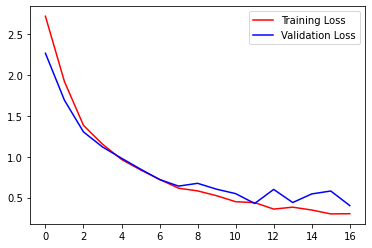

In [36]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

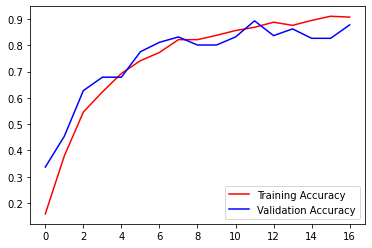

In [37]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [38]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )
print(classification_report(np.argmax(Y_test14, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.696     0.948     0.803        58
           1      0.706     0.590     0.643        61
           2      0.738     0.564     0.639        55
           3      0.684     0.765     0.722        51
           4      0.839     0.945     0.889        55
           5      0.941     0.828     0.881        58
           6      1.000     0.952     0.975        62
           7      0.697     0.981     0.815        54
           8      0.885     0.794     0.837        68
           9      0.979     0.770     0.862        61
          10      1.000     0.899     0.947        69
          11      0.950     1.000     0.974        57
          12      0.934     0.983     0.958        58
          13      0.803     0.781     0.792        73

    accuracy                          0.842       840
   macro avg      0.847     0.843     0.838       840
weighted avg      0.851     0.842     0.840       840



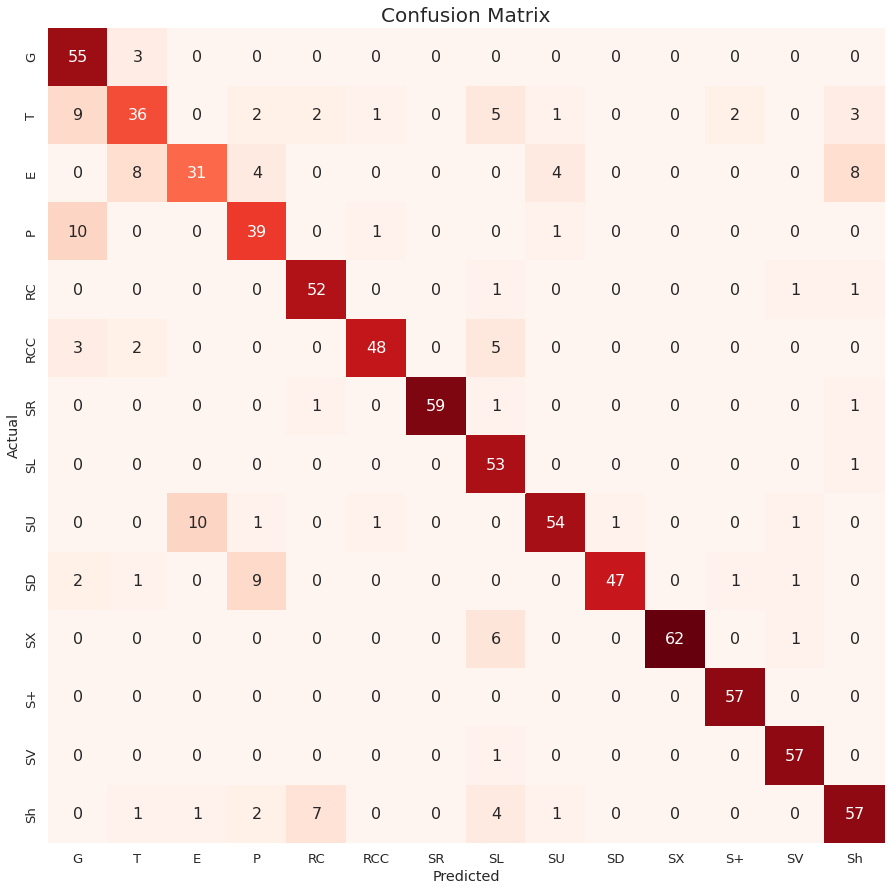

In [42]:
Labels  = ['G', 'T' ,'E', 'P', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Sh']

cm_data = confusion_matrix(np.argmax(Y_test14, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=Labels, index = Labels)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,15))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Reds", annot=True, annot_kws={"size": 16}, fmt='g')

# Model for 28 Classes

In [54]:
inp = []
out = []
for i in range(66):
  input_1 = Input(shape=(100,1))
  x = Conv1D(filters=8, kernel_size=3, activation='relu')(input_1)
  x = AveragePooling1D(pool_size=2)(x)
  x = Conv1D(filters=8, kernel_size=1, activation='relu')(x)
  x = AveragePooling1D(pool_size=2)(x)
  x = Conv1D(filters=4, kernel_size=1, activation='relu')(x)
  x = AveragePooling1D(pool_size=2)(x)
  flat_1 = Flatten()(x)

  # input_2 = Input(shape=(100,1))
  x = AveragePooling1D(pool_size=2)(input_1)
  x = AveragePooling1D(pool_size=2)(x)
  x = AveragePooling1D(pool_size=2)(x)
  flat_2 = Flatten()(x)

  # input_3 = Input(shape=(100,1))
  x = Conv1D(filters=8, kernel_size=7, activation='relu')(input_1)
  x = AveragePooling1D(pool_size=2)(x)
  x = Conv1D(filters=8, kernel_size=7, activation='relu')(x)
  x = AveragePooling1D(pool_size=2)(x)
  x = Conv1D(filters=4, kernel_size=7, activation='relu')(x)
  x = AveragePooling1D(pool_size=2)(x)
  flat_3 = Flatten()(x)

  merged = concatenate([flat_1, flat_2, flat_3])

  inp.append(input_1)
  out.append(merged)

out_merged = concatenate(out)
dropout = keras.layers.Dropout(0.2)(out_merged)
dense_1 = Dense(1996, activation='relu')(dropout)
output = Dense(28, activation='softmax')(dense_1)

In [55]:
model_28 = Model(inputs=inp, outputs=output)
model_28.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.98,epsilon=1e-08))

# summarize
# print(model.summary())
# plot_model(model, show_shapes=True, to_file='multichannel.png')

In [56]:
checkpointer_28 = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model_28.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [57]:
history_28 = model_28.fit(x=X_train,
                    y=Y_train28,
                    epochs=20,
                    batch_size=32,   
                    verbose=1,
                    callbacks=[checkpointer_28],
                    validation_split=0.1)

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 3.3820 - accuracy: 0.0896
Epoch 1: val_accuracy improved from -inf to 0.06633, saving model to best_model_28.h5
56/56 [==============================] - 72s 424ms/step - loss: 3.3820 - accuracy: 0.0896 - val_loss: 3.1430 - val_accuracy: 0.0663
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 2.6627 - accuracy: 0.2353
Epoch 2: val_accuracy improved from 0.06633 to 0.24490, saving model to best_model_28.h5
56/56 [==============================] - 18s 321ms/step - loss: 2.6627 - accuracy: 0.2353 - val_loss: 2.3972 - val_accuracy: 0.2449
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 2.0427 - accuracy: 0.3588
Epoch 3: val_accuracy improved from 0.24490 to 0.44898, saving model to best_model_28.h5
56/56 [==============================] - 11s 199ms/step - loss: 2.0427 - accuracy: 0.3588 - val_loss: 1.8857 - val_accuracy: 0.4490
Epoch 4/20
56/56 [==============================] - ETA: 0

# Test Model 28:

In [66]:
model_28 = keras.models.load_model('best_model_28.h5')

loss = model_28.evaluate(X_test,Y_test28)
print(F'Test Accuracy: {loss[1]:.2f}%')

27/27 [==============================] - 11s 75ms/step - loss: 0.7385 - accuracy: 0.7714
Test Accuracy: 0.77%


# Results 28:

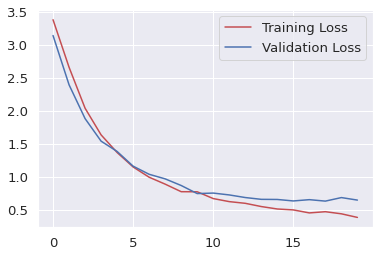

In [59]:
plt.plot(history_28.history["loss"],'r', label="Training Loss")
plt.plot(history_28.history["val_loss"],'b', label="Validation Loss")
plt.legend()

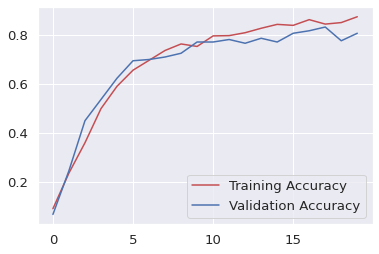

In [60]:
plt.plot(history_28.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history_28.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [61]:
preds_28 = model_28.predict(X_test)
y_pred_28 = np.argmax(preds_28 , axis = 1 )
print(classification_report(np.argmax(Y_test28, axis = 1 ),y_pred_28,digits=3))

              precision    recall  f1-score   support

           0      0.760     0.679     0.717        28
           1      0.604     0.967     0.744        30
           2      0.692     0.545     0.610        33
           3      0.750     0.429     0.545        28
           4      0.773     0.630     0.694        27
           5      0.700     0.750     0.724        28
           6      0.900     0.333     0.486        27
           7      0.750     0.750     0.750        24
           8      0.694     0.862     0.769        29
           9      0.833     0.769     0.800        26
          10      0.595     0.688     0.638        32
          11      0.538     0.808     0.646        26
          12      0.882     0.909     0.896        33
          13      0.893     0.862     0.877        29
          14      0.556     0.769     0.645        26
          15      0.735     0.893     0.806        28
          16      0.852     0.719     0.780        32
          17      0.732    

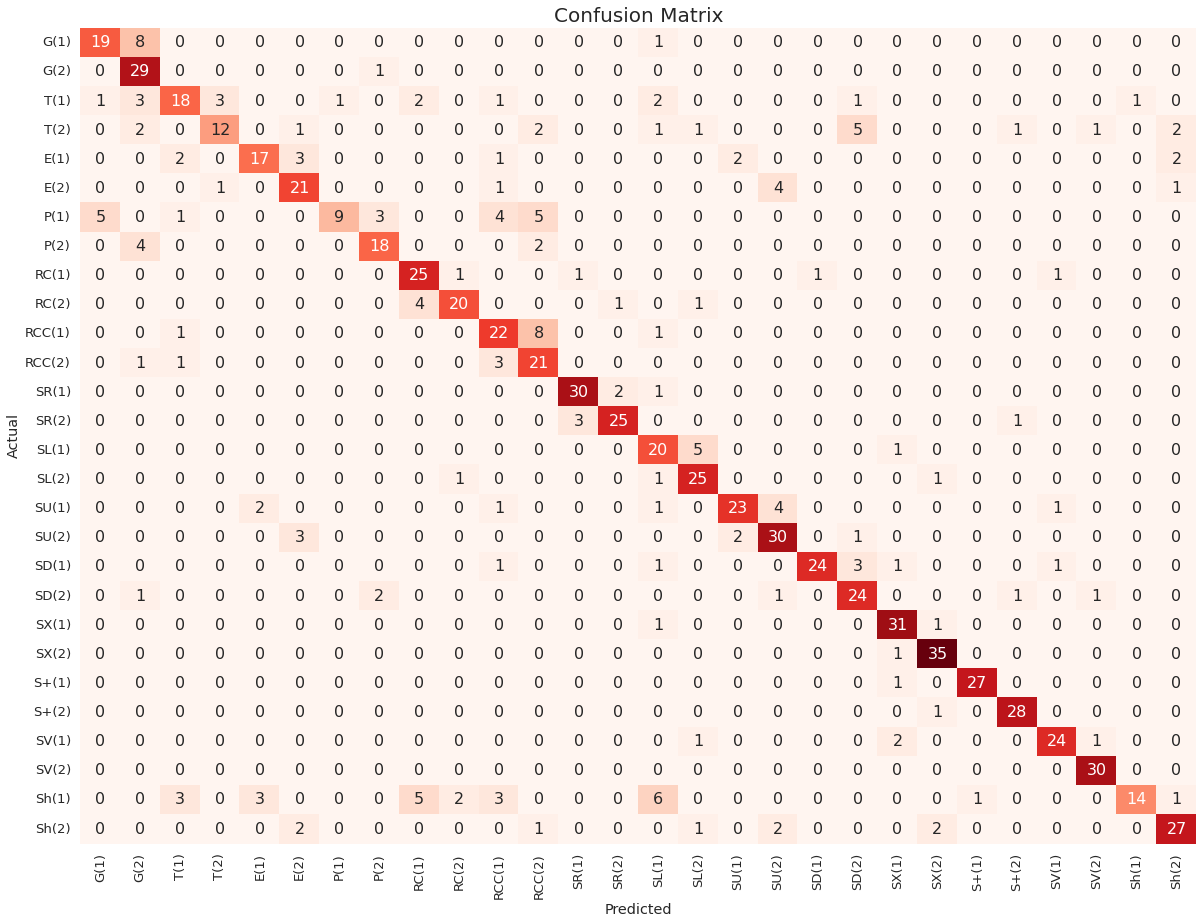

In [63]:
Labels28  = ['G(1)', 'G(2)', 'T(1)','T(2)','E(1)','E(2)', 'P(1)','P(2)', 'RC(1)','RC(2)', 'RCC(1)','RCC(2)', 'SR(1)','SR(2)', 'SL(1)','SL(2)', 'SU(1)','SU(2)', 'SD(1)','SD(2)', 'SX(1)','SX(2)', 'S+(1)','S+(2)', 'SV(1)','SV(2)', 'Sh(1)','Sh(2)']

cm_data = confusion_matrix(np.argmax(Y_test28, axis = 1 ), y_pred_28)
cm = pd.DataFrame(cm_data, columns=Labels28, index = Labels28)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,15))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Reds", annot=True, annot_kws={"size": 16}, fmt='g')